In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from scipy.optimize import curve_fit
from scipy import stats

import dataloader
import preprocessing
import sampling


# Load data

In [2]:
ERSP_all, tmp_all, freqs = dataloader.load_data()

(452, 12, 114, 200)
(452, 3)
(114,)


# Data preprocessing

In [3]:

'''
num_epoch = ERSP_all.shape[0]
num_channel = ERSP_all.shape[1]

# Average over time
ERSP_all = np.mean(ERSP_all, axis=3)

# Subtract the base spectrum (trials <= 5s)
SLs = tmp_all[:, 2]
base = np.mean(ERSP_all[np.where(SLs<=5)[0], :, :], axis=0)
ERSP_all = ERSP_all - base[np.newaxis, :, :]
'''
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

## Remain original ERSP

In [4]:
num_epoch = ERSP_all.shape[0]
method = 3 # 1,2,3

if method != 3:
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    
else:
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    # Average power over channels (LDA directly)
    ERSP_all = np.mean(ERSP_all, axis=2)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''

Shape of ERSP_all:  (452, 1368)


## Trim mean

In [4]:
ERSP_all, new_SLs = preprocessing.trimMean(ERSP_all, SLs, freqs)
Y = preprocessing.make_target(new_SLs)

method = 3

## Bandpower

In [4]:
ERSP_1 = preprocessing.bandpower(ERSP_all, freqs, 5, 10)
ERSP_2 = preprocessing.bandpower(ERSP_all, freqs, 10, 15)
ERSP_all = np.concatenate((ERSP_1, ERSP_2), axis=1)

threshold = np.mean(SLs)+np.std(SLs)
print(threshold)
Y = preprocessing.make_target(SLs, threshold)

method = 3

25.554513197351692


# Holdout Method

## Split data

In [5]:
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(ERSP_all, Y, test_size=0.1, random_state=42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (406, 1368)
X_test shape :  (46, 1368)


## PCA (1) Largest eigenvalues

In [5]:
# Apply PCA to training data and testing data
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

NameError: name 'X_train' is not defined

## PCA (2) Most correlated

In [5]:
def PCA_corr(X_train, X_test, Y_train):
    # PCA fit
    num_train = X_train.shape[0]
    mean_X = 1/num_train * np.dot(X_train.T, np.ones((num_train,1))).T
    cen_X_train = X_train - mean_X
    cov_X_train = 1/num_train * np.dot(cen_X_train.T, cen_X_train)
    w, v = np.linalg.eig(cov_X_train)

    # Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(w)[::-1]
    sorted_v = v[:, sorted_indices]
    sorted_w = np.sort(w)[::-1]

    # Retain PCs with 80% eigenvalues
    ratios = np.add.accumulate(sorted_w.real)/np.sum(sorted_w.real)
    num_PCs = np.sum(ratios<=0.8)
    PCs = sorted_v[:, :num_PCs]

    # PCA predict
    X_train = np.dot(cen_X_train, PCs)

    # Find two PCs correlated most strongly with SLs
    corr_coef = np.zeros(num_PCs)
    for i in range(num_PCs):
        corr_coef[i] = abs(np.corrcoef(X_train[:,i], Y_train[:,1])[0,1])

    #print(corr_coef)
    max_1_index = np.argmax(corr_coef)
    #print('Max: ', max_1_index)
    corr_coef[max_1_index] = 0
    max_2_index = np.argmax(corr_coef)
    #print('Second: ', max_2_index)
    PC_2 = sorted_v[:, [max_1_index, max_2_index]]


    # PCA predict
    X_train = abs(np.dot(cen_X_train, PC_2))
    X_test = abs(np.dot(X_test-mean_X, PC_2))

    #print('X_train shape : ', X_train.shape)
    #print('X_test shape : ', X_test.shape)
    
    return X_train, X_test

In [7]:
X_train, X_test = PCA_corr(X_train, X_test, Y_train)

[0.10016149 0.13321825 0.19431854 0.1501953  0.1506912  0.05088907
 0.14942456 0.12343108 0.06527064 0.0030398  0.02589858 0.06059784
 0.06922075 0.04778581 0.0834417  0.08851105 0.09370633 0.03329117
 0.08084067 0.00824471 0.00701375 0.09780048 0.05044458 0.0233989 ]
Max:  2
Second:  4


In [8]:
# Sort SLs in increasing order
sorted_indices = np.argsort(Y_train[:,1])
sorted_x = X_train[sorted_indices, :]
sorted_y = Y_train[sorted_indices, :]

# Curve fitting
def func(X, a, b, c):
    x1, x2 = X
    return a + b*x1 + c*x2

xdata = (sorted_x[:,0], sorted_x[:,1])
ydata = sorted_y[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

Text(0.5, 1.0, 'r = 0.043601')

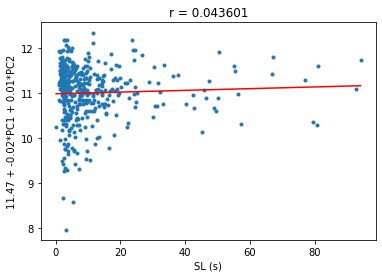

In [9]:
# Plot them
y_reg = func(xdata, popt[0], popt[1], popt[2])
plt.scatter(ydata, y_reg, marker = '.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ydata, y_reg)
y_range = np.linspace(np.min(ydata), np.max(ydata), 100)
plt.plot(y_range, slope*y_range+intercept, 'r-')

plt.xlabel('SL (s)')
plt.ylabel('%.2f + %.2f*PC1 + %.2f*PC2'%(popt[0],popt[1],popt[2]))
plt.title('r = %f'%(np.corrcoef(y_reg, ydata)[0,1]))


# Leave-one-out cross validation

In [5]:
X_all = ERSP_all

test_acc_SL = []
thresholds = list(range(1,50))

for threshold in thresholds:
    Y = preprocessing.make_target(SLs, float(threshold))
    
    train_acc_list = []
    test_acc_list = []
    loo = LeaveOneOut()
    for i, (train_index, test_index) in enumerate(loo.split(X_all)):

        # No trim mean
        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        if method == 1:
            pca = PCA(n_components=2)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            # PCA
            X_train, X_test = PCA_corr(X_train, X_test, Y_train)

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]

        '''
        # Trim mean after removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        X_train, new_SLs = trimMean(X_train, SLs[train_index], freqs)
        X_test = bandpower(X_test, freqs, 10, 15)

        # Let mean of SLs be the threshold
        threshold = np.mean(new_SLs) 
        Y_train = np.asarray(new_SLs >= threshold, float)
        Y_test = np.asarray(SLs[test_index] >= threshold, float)
        '''

        '''
        # Trim mean before removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]
        '''

        # LDA
        clf = svm.SVC()
        clf.fit(X_train, Y_train)

        num_train = len(Y_train)
        pred_train = clf.predict(X_train)
        train_acc = np.sum(pred_train == Y_train)/num_train*100
        #print('Training Accuracy : %f'%(train_acc))
        train_acc_list.append(train_acc)

        num_test = len(Y_test)
        pred_test = clf.predict(X_test)
        test_acc = np.sum(pred_test == Y_test)*100
        #print('Testing Accuracy : %f'%(test_acc))
        test_acc_list.append(test_acc)

        # print('Iteration %d: (%f, %f)'%(i, train_acc, test_acc))
        
    print('Threshold %d: %f'%(threshold, sum(test_acc_list)/len(test_acc_list)))
    test_acc_SL.append(sum(test_acc_list)/len(test_acc_list))
    

Threshold 1: 99.557522
Threshold 2: 88.716814
Threshold 3: 75.663717
Threshold 4: 64.823009
Threshold 5: 62.168142
Threshold 6: 66.150442
Threshold 7: 70.796460
Threshold 8: 70.796460
Threshold 9: 71.902655
Threshold 10: 73.672566
Threshold 11: 76.327434
Threshold 12: 76.106195
Threshold 13: 77.876106
Threshold 14: 77.876106
Threshold 15: 80.973451
Threshold 16: 82.964602
Threshold 17: 83.849558
Threshold 18: 85.176991
Threshold 19: 86.504425
Threshold 20: 87.389381
Threshold 21: 87.610619
Threshold 22: 88.053097
Threshold 23: 88.938053
Threshold 24: 89.601770
Threshold 25: 90.929204
Threshold 26: 91.150442
Threshold 27: 91.371681
Threshold 28: 91.371681
Threshold 29: 91.592920
Threshold 30: 91.592920
Threshold 31: 92.256637
Threshold 32: 92.699115
Threshold 33: 93.141593
Threshold 34: 93.362832
Threshold 35: 93.362832
Threshold 36: 93.362832
Threshold 37: 93.584071
Threshold 38: 94.026549
Threshold 39: 94.026549
Threshold 40: 94.026549
Threshold 41: 94.247788
Threshold 42: 94.247788
T

In [6]:
test_acc_array = np.asarray(test_acc_list)
false_trials = SLs[np.where(test_acc_array==0)[0]]
true_trials = SLs[np.where(test_acc_array==100)[0]]
print('False trials, Min: %f, Max: %f'%(np.min(false_trials), np.max(false_trials)))
print('True trials, Min: %f, Max: %f'%(np.min(true_trials), np.max(true_trials)))

False trials, Min: 26.693359, Max: 94.105469
True trials, Min: 0.152344, Max: 25.238281


In [6]:
print('Training accuracy: %f'%(sum(train_acc_list)/len(train_acc_list)))
print('Testing accuracy: %f'%(sum(test_acc_list)/len(test_acc_list)))

Training accuracy: 91.150442
Testing accuracy: 91.150442


Text(0, 0.5, 'Accuracy (%)')

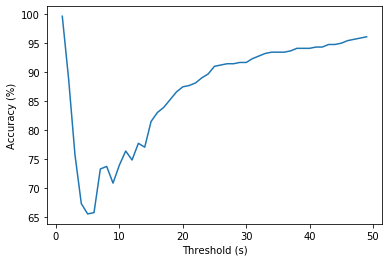

In [9]:
plt.plot(thresholds, test_acc_SL)
plt.xlabel('Threshold (s)')
plt.ylabel('Accuracy (%)')

In [6]:
ratios = []
for threshold in thresholds:
    ratio = max(np.sum(SLs<=threshold), np.sum(SLs>threshold))/len(SLs)
    ratios.append(ratio*100)

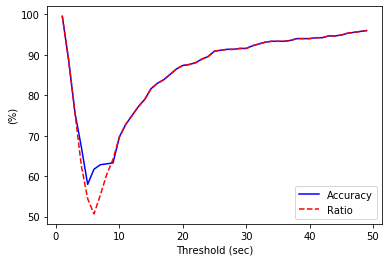

In [7]:
plt.plot(thresholds, test_acc_SL, 'b-', thresholds, ratios, 'r--')
plt.xlabel('Threshold (sec)')
plt.ylabel('(%)')
plt.legend(('Accuracy', 'Ratio'))

# Regression

In [5]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

In [12]:
num_fold = 10
train_std = np.zeros((num_fold, 3))
test_std = np.zeros((num_fold, 3))
kf = KFold(n_splits=num_fold)

X_all = ERSP_all
Y = preprocessing.make_target(SLs)
for i, (train_index, test_index) in enumerate(kf.split(X_all)):
    # Split data
    X_train, X_test = X_all[train_index], X_all[test_index]
    Y_train, Y_test = Y[train_index, :], Y[test_index, :]
    
    if method == 1:
        pca = PCA(n_components=2)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    elif method == 2:
        # PCA
        X_train, X_test = PCA_corr(X_train, X_test, Y_train)
    
    # Decompose Y
    Y_train_cla, Y_train_reg = Y_train[:,0], Y_train[:,1]
    Y_test_cla, Y_test_reg = Y_test[:,0], Y_test[:,1]
    
    # 1. Regression directly
    rgr = svm.SVR()
    rgr.fit(X_train, Y_train_reg)
    pred_train_reg = rgr.predict(X_train)
    pred_test_reg = rgr.predict(X_test)
    train_std[i,0] = standard_error(pred_train_reg, Y_train_reg)
    test_std[i,0] = standard_error(pred_test_reg, Y_test_reg)
    
    # 2. Undersampling -> Regression
    rgr = svm.SVR()
    new_X_train, new_Y_train_reg = sampling.undersampling(X_train, Y_train_reg)
    rgr.fit(new_X_train, new_Y_train_reg)
    pred_train_reg = rgr.predict(new_X_train)
    pred_test_reg = rgr.predict(X_test)
    train_std[i,1] = standard_error(pred_train_reg, new_Y_train_reg)
    test_std[i,1] = standard_error(pred_test_reg, Y_test_reg)
    
    # 3. SMOTE -> Regression
    rgr = svm.SVR()
    new_X_train, new_Y_train_reg = sampling.SMOTER(X_train, Y_train_reg)
    rgr.fit(new_X_train, new_Y_train_reg)
    pred_train_reg = rgr.predict(new_X_train)
    pred_test_reg = rgr.predict(X_test)
    train_std[i,2] = standard_error(pred_train_reg, new_Y_train_reg)
    test_std[i,2] = standard_error(pred_test_reg, Y_test_reg)
    
    print('---Iteration %d---\n'%(i))
    print('Method 1: %f | %f\n'%(train_std[i,0], test_std[i,0]))
    print('Method 2: %f | %f\n'%(train_std[i,1], test_std[i,1]))
    print('Method 3: %f | %f\n'%(train_std[i,2], test_std[i,2]))
    

---Iteration 0---

Method 1: 14.513974 | 15.309187

Method 2: 17.472300 | 13.465454

Method 3: 14.824252 | 14.521524

---Iteration 1---

Method 1: 15.117046 | 3.115566

Method 2: 18.033213 | 6.584478

Method 3: 16.152566 | 4.457257

---Iteration 2---

Method 1: 15.077597 | 2.841554

Method 2: 17.925301 | 4.670174

Method 3: 16.155320 | 4.891459

---Iteration 3---

Method 1: 14.974143 | 4.726564

Method 2: 18.221578 | 7.554946

Method 3: 15.306558 | 7.708062

---Iteration 4---

Method 1: 12.726150 | 26.965913

Method 2: 15.412267 | 24.674484

Method 3: 12.980642 | 24.944553

---Iteration 5---

Method 1: 14.844272 | 7.786003

Method 2: 18.355124 | 8.846531

Method 3: 15.800888 | 9.100407

---Iteration 6---

Method 1: 14.945959 | 7.549641

Method 2: 18.168976 | 8.054544

Method 3: 16.700850 | 8.072007

---Iteration 7---

Method 1: 15.157161 | 4.501963

Method 2: 17.897499 | 6.928675

Method 3: 16.057862 | 5.412539

---Iteration 8---

Method 1: 13.734544 | 20.376197

Method 2: 16.336435 | 

Testing stadard error:

Method 1: 12.050055
Method 2: 12.520762
Method 3: 12.187467


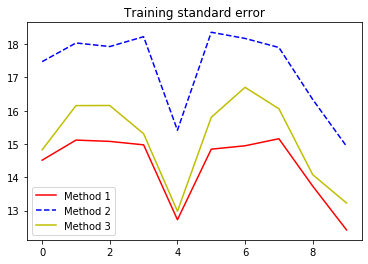

In [14]:
# Plot result
iterations = list(range(num_fold))
plt.plot(iterations, train_std[:,0], 'r-', iterations, train_std[:,1], 'b--', iterations, train_std[:,2], 'y-')
plt.legend(('Method 1', 'Method 2', 'Method 3'))
plt.title('Training standard error')

print('Testing stadard error:\n')
print('Method 1: %f'%(np.mean(test_std[:,0])))
print('Method 2: %f'%(np.mean(test_std[:,1])))
print('Method 3: %f'%(np.mean(test_std[:,2])))

In [6]:
Y = preprocessing.make_target(SLs)
X = preprocessing.PCA_corr(ERSP_all, Y)

Y = SLs
clf = LinearRegression()
clf.fit(X, SLs)
pred_Y = clf.predict(X)

print(standard_error(pred_Y, SLs))


14.573596296478206


In [13]:
std_list = []
for remove_threshold in range(2,80,2):
    keep_index = np.where(SLs<remove_threshold)[0]
    Y = preprocessing.make_target(SLs[keep_index])
    X = preprocessing.PCA_corr(ERSP_all[keep_index,:], Y)
    
    clf = LinearRegression()
    clf.fit(X, SLs[keep_index])
    pred_Y = clf.predict(X)
    
    error = standard_error(pred_Y, SLs[keep_index])/np.mean(SLs[keep_index])
    std_list.append(error)
    print('%d: %f, %f, %f'%(remove_threshold, error, np.std(pred_Y), np.mean(pred_Y)))

2: 0.227792, 0.022287, 1.549747
4: 0.316536, 0.177593, 2.544668
6: 0.400953, 0.064990, 3.142476
8: 0.486446, 0.132389, 3.758113
10: 0.556108, 0.199316, 4.465526
12: 0.592101, 0.073994, 4.918026
14: 0.622258, 0.373620, 5.318972
16: 0.662323, 0.258026, 5.774792
18: 0.686232, 0.458359, 6.068177
20: 0.714017, 0.608832, 6.394759
22: 0.725943, 0.620537, 6.506002
24: 0.760528, 0.516300, 6.791647
26: 0.791997, 0.444091, 7.093413
28: 0.798112, 0.358741, 7.140871
30: 0.805667, 0.265348, 7.193029
32: 0.842114, 0.445752, 7.474535
34: 0.865391, 0.432813, 7.654649
36: 0.865391, 0.432813, 7.654649
38: 0.897797, 0.315483, 7.864453
40: 0.897797, 0.315483, 7.864453
42: 0.910064, 0.264847, 7.940443
44: 0.936607, 0.194502, 8.102306
46: 0.975032, 0.491543, 8.359701
48: 1.001812, 0.158601, 8.537376
50: 1.038708, 0.433478, 8.818655
52: 1.050843, 0.305227, 8.913575
54: 1.063149, 0.262102, 9.012058
56: 1.100628, 0.353763, 9.323820
58: 1.124370, 0.246925, 9.537929
60: 1.124370, 0.246925, 9.537929
62: 1.124370, 

(array([ 3., 50., 56., 54., 38., 24., 22., 21., 16., 21., 19.,  7., 11.,
        12.,  6.,  9.,  6.,  4.,  6.,  6.,  4.,  1.,  1.,  4.,  2.,  7.,
         2.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.15234375,  1.091875  ,  2.03140625,  2.9709375 ,  3.91046875,
         4.85      ,  5.78953125,  6.7290625 ,  7.66859375,  8.608125  ,
         9.54765625, 10.4871875 , 11.42671875, 12.36625   , 13.30578125,
        14.2453125 , 15.18484375, 16.124375  , 17.06390625, 18.0034375 ,
        18.94296875, 19.8825    , 20.82203125, 21.7615625 , 22.70109375,
        23.640625  , 24.58015625, 25.5196875 , 26.45921875, 27.39875 

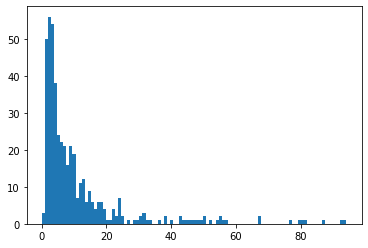

In [18]:
plt.hist(SLs, bins=100)

In [8]:
max(SLs)

94.10546875